# Implementation on quantum circuits

In [1]:
%load_ext nb_mypy
%nb_mypy On
    
%matplotlib ipympl

Version 1.0.4


In [40]:
import matplotlib.pyplot as plt
import nlsa.fourier_s1 as f1
import nlsa.fourier_t2 as f2
import nlsa.function_algebra as fun
import nlsa.vector_algebra as vec
import numpy as np

from functools import partial
from ipywidgets import widgets, interactive, interact, IntSlider, FloatSlider
from more_itertools import take
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from multiprocess import Pool
from nlsa.abstract_algebra import compose_by, multiply_by
from nlsa.dynamics import circle_rotation, orbit
from nlsa.function_algebra import compose, fmap
from nlsa.matrix_algebra import pure_state
from nptyping import Complex, Double, Int, NDArray, Shape
from qiskit import Aer, QuantumCircuit, QuantumRegister, transpile
from qiskit.extensions import UnitaryGate
from qiskit.tools.visualization import plot_histogram
from scipy.linalg import block_diag, eig, norm, polar
from typing import Callable, Tuple, TypeVar

In [29]:
I = int
I2 = Tuple[int, int]
R = float
R2 = Tuple[float, float]

X = NDArray[Shape["*"], Double]
X2 = NDArray[Shape["*, 2"], Double]
Y = NDArray[Shape["*"], Double]
F = Callable[[X], Y]
F2 = Callable[[X2], Y]

N = TypeVar("N")
K = NDArray[Shape["N"], Int]
V = TypeVar("V", NDArray[Shape["N"], Double], NDArray[Shape["N"], Complex])
W = TypeVar("W",
            NDArray[Shape["*, N"], Double],
            NDArray[Shape["*, N"], Complex])
M = TypeVar("M",
            NDArray[Shape["N, N"], Double],
            NDArray[Shape["N, N"], Complex])

In [4]:
def eig_sorted(a: M) -> Tuple[V, M]:
    w, v = eig(a)
    idx = w.real.argsort()
    w = w[idx]
    v = v[:, idx]
    return w, v

## Von Mises density on the circle

In [5]:
def vm(kappa: R) -> F:
    """Von Mises density centered at pi."""
    f: F = f1.von_mises(kappa, loc=np.pi)
    return f


def vm_fourier(kappa: R, l: I) -> V:
    """Fourier coefficients of von Mises density centered at pi."""
    vm_hat = f1.von_mises_fourier(kappa, loc=np.pi)
    f_hat: V = vm_hat(f1.dual_group(l))
    return f_hat


def vm_mult_op(kappa: R, l: I) -> M:
    """Projected multiplication operator induced by von Mises density.""" 
    mult_op = f1.make_mult_op(l)
    f_mult: M = mult_op(vm_fourier(kappa, 2 * l))
    return f_mult

In [6]:
def feature_map(epsilon: R, l: I) -> Callable[[X], W]:
    """Feature map based on von Mises density."""
    kappa = epsilon ** -2
    xi_0 = f1.von_mises_feature_map(kappa, f1.dual_group(l))
    z = np.linalg.norm(xi_0(np.array([0])))
    
    def xi(x: X) -> W:
        return xi_0(x) / z
    return xi


def qm_recon(a: M, xi: Callable[[X], W]) -> Callable[[X], Y]:
    """Reconstructs classical observable (function) from quantum mechanical
    observable and feature map.
    
    """
    def f(x: X) -> Y:
        omega = pure_state(xi(x))
        return omega(a)
    return f

## Classical and quantum approximations of von Mises density

$q$ is the number of qubits and $l$ is the maximal Fourier wavenumber in the Hilbert space of classical observables, $H_l$. The dimension of $H_l$ is $d = 2 l + 1$. We choose $l$ such that $d = 2^q - 1$.   

In [7]:
kappa = 10
epsilon = 0.05
q = 7

l = 2 ** (q - 1) - 1

mult_op = f1.make_mult_op(l)
synth = partial(fun.synthesis, f1.fourier_basis(f1.dual_group(l)))

f = vm(kappa)
f_hat = vm_fourier(kappa, l)
f_mul = mult_op(vm_fourier(kappa, 2 * l))

y, c = eig_sorted(f_mul)

qsynth = partial(qm_recon, f_mul)
xi = feature_map(epsilon, l)

In [12]:
i_fig = 1

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax2 = ax.twinx()
j_slider = IntSlider(value=0, min=0, max=n_plt_eig, continuous_update=False)

@interact(j=j_slider) 
def plotfunc_eig(j):
    n_plt_x = 256
    n_plt_eig = y.size - 1
    x = np.linspace(0, 2 * np.pi, n_plt_x)
    x1 = x / np.pi
    fx = f(x)
    u = synth(c[:, j])
    lam = y[j].real
    ux = u(x)
    if norm(ux.real) > norm(ux.imag):
        ux_plt = ux.real
    else:
        ux_plt = ux.imag
    if np.max(ux_plt) < np.max(-ux_plt):
        ux_plt = -1 * ux_plt
    ax.cla()
    ax2.cla()
    ax2._get_lines.prop_cycler = ax._get_lines.prop_cycler
    ax.plot(x1, ux_plt, label="$u_j$")
    ax2.plot(x1, fx, label="$f$")
    ax2.axhline(y=lam, color='g', label="$\lambda_j$")
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2)
    ax2.set_ylabel("$f$, $\lambda_j$")
    ax2.set_xlim(0, 2)
    ax.grid()
    ax.set_xlabel("$\\theta_1/\\pi$")
    ax.set_ylabel("$u_j$")
    ax.set_xlim(0, 2)
    ax.set_title(f"Eigenfunction $u_{{{j}}}$, $\lambda_{{{j}}} = {lam:.3g}$")
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='j', max=126), Output()), _dom_c…

## Classical and quantum approximations of ergodic rotation

In [34]:
a_2pi = 1 / np.sqrt(20)

a = 2 * np.pi * a_2pi

spec = f1.rotation_koopman_eigs(a)
u = compose_by(fun, circle_rotation(a))
u_vec = spec(f1.dual_group(l))
u_cl = multiply_by(vec, u_vec)
u_qm = fmap(multiply_by(vec, u_vec.conj()))

In [13]:
n_iter = 20
n_par = 2
i_fig = 2

f_orb = orbit(f, u)
fn = take(n_iter + 1, f_orb) 

f_hat_orb = orbit(f_hat, u_cl)
f_cl_orb  = map(synth, f_hat_orb)
fn_cl = take(n_iter + 1, f_cl_orb) 

pl = Pool(n_par)
xi_orb = orbit(xi, u_qm)
f_qm_orb  = map(qsynth, xi_orb)
fn_qm = take(n_iter + 1, f_qm_orb) 

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
n_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(n=n_slider) 
def plotfunc_recon(n):
    n_plt_x = 128
    x = np.linspace(0, 2*np.pi, n_plt_x)
    x1 = x / np.pi
    fx = fn[n](x)
    f_clx = np.real(fn_cl[n](x))
    f_qmx = np.real(pl.map(fn_qm[n], x))
    ax.cla()
    ax.plot(x1, fx, label="true")
    ax.plot(x1, f_clx, label="classical")
    ax.plot(x1, f_qmx, label="quantum")
    ax.legend()
    ax.set_xlim(0, 2)
    ax.grid()
    ax.set_xlabel("$\\theta_1/\\pi$")
    ax.set_title(f'Circle rotation by angle $a={a_2pi:.3f}\\times 2\pi$; iteration $n= {n}$')
    plt.show()

interactive(children=(IntSlider(value=0, continuous_update=False, description='n', max=20), Output()), _dom_cl…

### Quantum circuit representation

In [58]:
def make_koopman_circuit(q: I, xi: Callable[[X], W], u: W, c: M) \
        -> Callable[[I, X], QuantumCircuit]:
    """Build Qiskit circuit that implements Koopman evolution of an observable.
    
    :q: Number of qubits.
    :xi: Feature map returning the quantum mechanical state vector as a 
    function of the classical initial condition.
    :u: Diagonal part of Koopman operator matrix.
    :c: Unitary matrix that contains the eigenvectors of the observable.
    :returns: Function that takes as inputs the number of timesteps and a  
    classical initial condition and returns a Qiskit circuit of q qubits that 
    implements the corresponding quantum Koopman evolution.
    
    """
    extra_dims = 2 ** q - u.size
    c_gate = UnitaryGate(
        block_diag(c, np.identity(extra_dims)))
    zero_pad = np.zeros(extra_dims)
    
    def circuit(n: I, x: X) -> QuantumCircuit:
        circ = QuantumCircuit(q)
        state_vec = np.concatenate((xi(x)[0], zero_pad))
        u_gate = UnitaryGate(
            np.diag(np.concatenate((u ** n, np.ones(extra_dims)))))
        circ.initialize(state_vec, circ.qubits)
        circ.append(u_gate, circ.qubits)
        circ.append(c_gate, circ.qubits)
        circ.measure_all()
        return circ
    return circuit


def predict_with_circuit(circ: QuantumCircuit, shots: I = 1024) -> Tuple[K, X]:
    """Probabilistic prediction with Qiskit circuit."""
    
    sim_backend = Aer.get_backend('qasm_simulator')
    sim_job = sim_backend.run(transpile(circ, sim_backend), shots=shots)
    sim_result = sim_job.result()

    counts = sim_result.get_counts(circ)
    idx: K = np.array([int(ket, 2) for ket in sorted(counts.keys())])
    density: X = np.array([counts[ket] for ket in sorted(counts.keys())]) \
               / shots 
    return idx, density

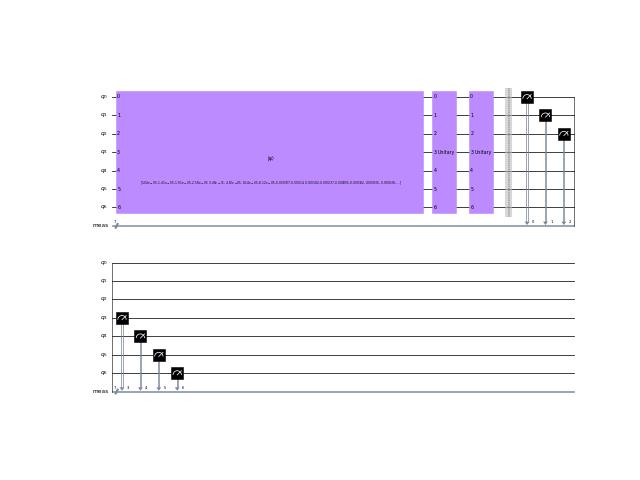

In [57]:
i_fig = 3

circ = make_koopman_circuit(q, feature_map(epsilon, l), u_vec.conj(), 
                            polar(c)[0].conj().T)

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
circ(1, np.array([0])).draw('mpl', ax=ax)
pl.show()

In [50]:
n_shots = 1024
i_fig = 4
if plt.fignum_exists(i_fig):
    plt.close(i_fig)
fig, ax = plt.subplots(num=i_fig)

x_slider = FloatSlider(value=0, min=0, max=2 * np.pi, continuous_update=False) 
n_slider = IntSlider(value=0, min=0, max=n_iter, continuous_update=False)

@interact(theta=x_slider, n=n_slider) 
def plotfunc_circ(theta, n):
    x_arr = np.array([theta])
    idx, density = predict_with_circuit(circ(n, x_arr), shots=n_shots)
    y_meas = y[idx].real
    ax.cla()
    ax.axvline(x=fn[n](x_arr), color='r', label="true value")
    ax.axvline(x=fn_qm[n](x_arr).real, 
               color='g', linewidth=5, label="qm expectation")
    ax.axvline(x=np.sum(y_meas * density), color='y', label="circuit mean")
    ax.plot(y_meas, density, '.-', label="circuit density")
    ax.set_xlabel("von Mises value")
    ax.set_ylabel("normalized counts")
    ax.set_title(f"Initial condition $\\theta={theta / np.pi:.3f} \\pi$; "
                 f"iteration $n={n}$")
    ax.legend()
    ax.grid()
    plt.show()

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='theta', max=6.2831853071795…

### Quantum circuit representation

The following are old cells that work for a single initial condition and one Koopman timestep.

`theta` is the classical initial condition on the circle. 

`u_mat` is a diagonal unitary matrix of size `(2 ** n, 2 ** n)`. The first `d = 2 * l + 1` diagonal entries of `u_mat` contain the eigenvalues of the Koopman operator associated with the circle rotation. The last (`2 ** n`) diagonal entry of `u_mat` is set to `1`, representing an identity transformation on the subspace spanned by the last computational basis vector.

`c_mat` is a block diagonal unitary matrix of size `(2 ** n, 2 ** n)`. The leading `(d, d)` diagonal block of `c_mat` is a unitary matrix whose columns are the eigenvectors of the multiplication operator representing the von Mises density. The last (`2 ** n`) diagonal entry of `c_mat` is set to `1`, representing an identity transformation on the subspace spanned by the last computational basis vector.

In principle, it should be possible to build `c_mat` from the array `c` containing the eigenvectors of the multiplication operator as computed by SciPy. However, it appears that `c` is not unitary at sufficient accuracy in order for it to be recognized by Qiskit as a unitary transformation. To address this issue we pass `c` through the polar decomposition, which appears to produce a unitary matrix at sufficient numerical accuracy. 

In [19]:
theta = np.array([8 * np.pi / 8])

u_mat = np.diag(np.concatenate((spec(-f1.dual_group(l)),
                                np.array([1]))))

c_mat = block_diag(polar(c)[0].conj().T, np.array([1]))

xi = feature_map(epsilon, l)
state_vec = np.concatenate((xi(theta)[0], np.array([0])))

circ = QuantumCircuit(q)
circ.initialize(state_vec, circ.qubits)
circ.append(UnitaryGate(u_mat), circ.qubits)
circ.append(UnitaryGate(c_mat), circ.qubits)
circ.measure_all()

In [21]:
n_shots = 1E5

sim_backend = Aer.get_backend('qasm_simulator')
sim_job = sim_backend.run(transpile(circ, sim_backend), shots=n_shots)
sim_result = sim_job.result()

counts = sim_result.get_counts(circ)
idx = np.array([int(ket, 2) for ket in sorted(counts.keys())])
density = np.array([counts[ket] for ket in sorted(counts.keys())]) / n_shots 
y_meas = y[idx].real

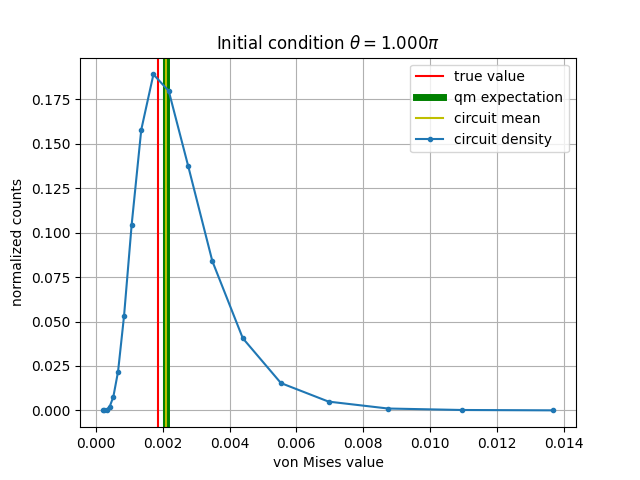

In [22]:
i_fig = 3

if plt.fignum_exists(i_fig):
    plt.close(i_fig)
    
fig, ax = plt.subplots(num=i_fig)
ax.axvline(x=fn[1](theta), color='r', label="true value")
ax.axvline(x=fn_qm[1](theta).real, color='g', linewidth=5, label="qm expectation")
ax.axvline(x=np.sum(y_meas * density), color='y', label="circuit mean")
ax.plot(y_meas, density, '.-', label="circuit density")
ax.set_xlabel("von Mises value")
ax.set_ylabel("normalized counts")
ax.set_title(f"Initial condition $\\theta={theta[0] / np.pi:.3f} \\pi$")
ax.legend()
ax.grid()
plt.show()